In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 28.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

# بخش آ

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/BBBP.csv', )

In [5]:
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [6]:
df['smiles_length'] = df['smiles'].apply(lambda x: len(x))

In [7]:
def calculate_mw(smiles):
    """
        This function calculates the weight of the molecules
    """
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol) if mol is not None else None

# Function to calculate number of atoms
def calculate_num_atoms(smiles):
    """
        This function calculates the number of atoms in the molecule
    """
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol is not None else None

df['molecular_weight'] = df['smiles'].apply(calculate_mw)
df['num_atoms'] = df['smiles'].apply(calculate_num_atoms)

[19:23:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] WARNING: not removing hydrogen atom without neighbors
[19:23:56] Explicit valence for atom # 11 N, 4, is greater than pe

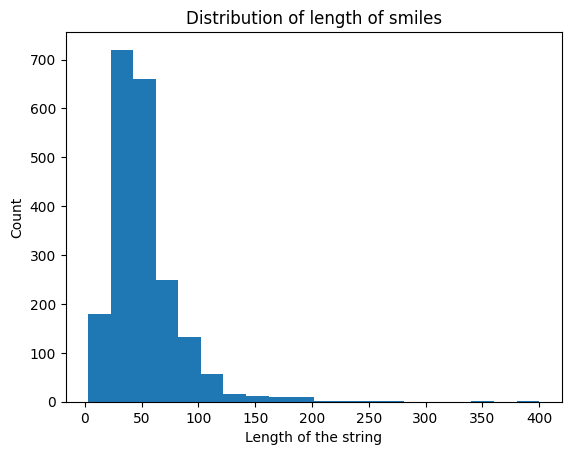

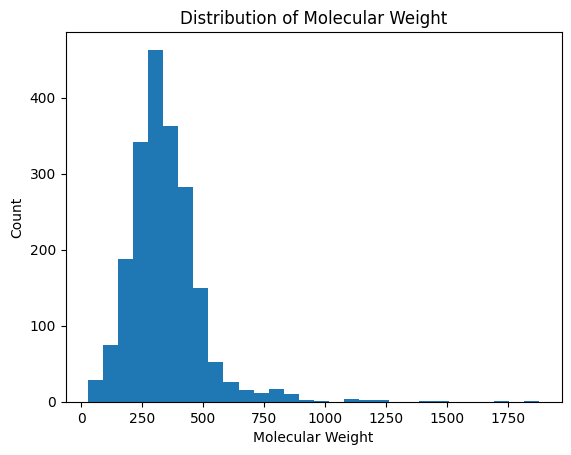

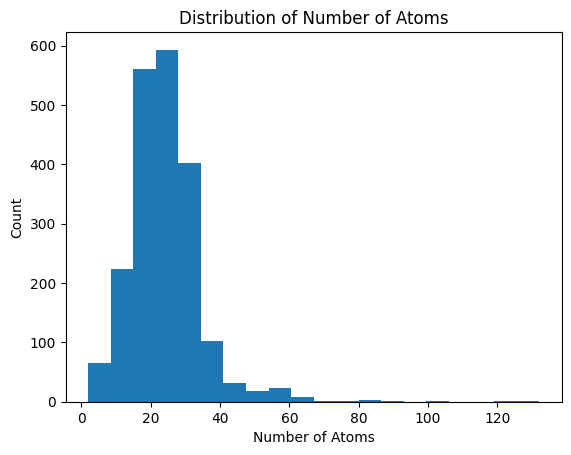

maximum length of the series: 400


In [8]:
# Plot histogram for number of atoms
plt.hist(df['smiles_length'], bins=20)
plt.xlabel('Length of the string')
plt.ylabel('Count')
plt.title('Distribution of length of smiles')
plt.show()

# Plot histogram for molecular weight
plt.hist(df['molecular_weight'].dropna(), bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.title('Distribution of Molecular Weight')
plt.show()

# Plot histogram for number of atoms
plt.hist(df['num_atoms'].dropna(), bins=20)
plt.xlabel('Number of Atoms')
plt.ylabel('Count')
plt.title('Distribution of Number of Atoms')
plt.show()

print(f"maximum length of the series: {max(df['smiles_length'])}")

As you can see in the above figures, the avg length of smile strings is 50 characters and most of the data is distributed around it with a low std. However, there are a few very large sequences as well (~400 chars)

### Tokenizing

In [9]:
all_smiles = ''.join(df['smiles'])
tokens = list(set(all_smiles))

token_counts = {token: all_smiles.count(token) for token in tokens}

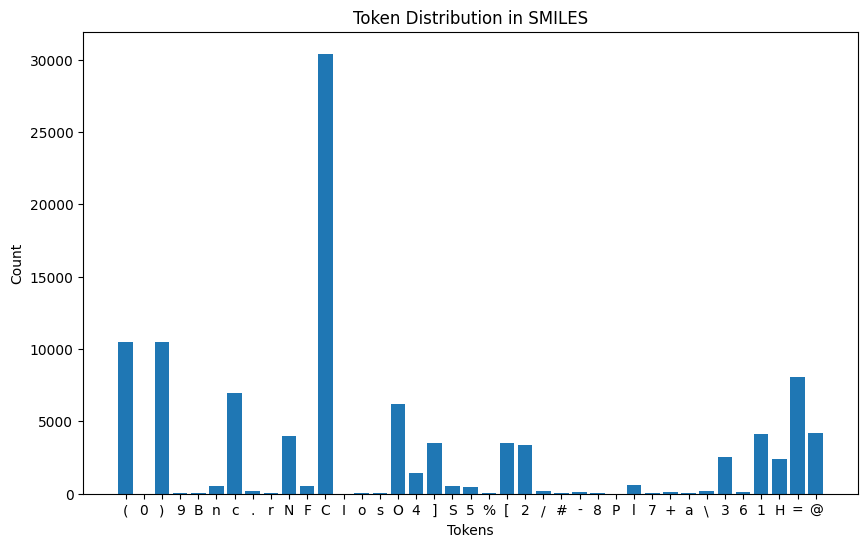

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(token_counts.keys(), token_counts.values())
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.title('Token Distribution in SMILES')
plt.show()

# بخش ب

In [11]:
token_to_index = {token: idx for idx, token in enumerate(tokens)}
index_to_token = {idx: token for token, idx in token_to_index.items()}

In [12]:
max(df['smiles_length'])

400

In [13]:
def encode_smiles(smiles):
    encoded = torch.zeros(max(df['smiles_length']), len(tokens))
    for i, char in enumerate(smiles):
        encoded[i][token_to_index[char]] = 1
    return encoded

# Encode all SMILES strings
encoded_smiles = [(encode_smiles(item.smiles), item.p_np) for _, item in df[['p_np', 'smiles']].iterrows()]

In [14]:
len(encoded_smiles)

2050

In [15]:
def split_dataset_test(data):
    test_ratio = 0.15
    test_size = int(test_ratio*len(data))
    train_val_size = len(data) - test_size
    train_val_dataset, test_dataset = random_split(data, [train_val_size, test_size])

    print(f"train size is {len(train_val_dataset)}")
    print(f"test size is {len(test_dataset)}")
    return train_val_dataset, test_dataset

In [16]:
train_val_dataset, test_dataset = split_dataset_test(encoded_smiles)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

train size is 1743
test size is 307


In [17]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.0)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(0.0)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        out = x.view(x.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [18]:
def train(model, train_loader, val_loader, epochs, optimizer, loss_function) -> (list, list, list, list):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(f"running on {device}")
    model.to(device)
    model.train()

    train_loss_values = []
    train_accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for i, data in enumerate(train_loader):

            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            # print(outputs)
            loss = loss_function(outputs, labels)
            # print(outputs)
            loss.backward()
            optimizer.step()

            # Calculate training loss
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total

        train_loss_values.append(epoch_train_loss)
        train_accuracy_values.append(epoch_train_accuracy)

        # print(f"Epoch [{epoch + 1}/{epochs}], "
        #     f"Train Loss: {epoch_train_loss:.4f}, "
        #     f"Train Accuracy: {100 * epoch_train_accuracy:.2f}%")

        if val_loader is not None:

            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_inputs)
                    val_loss = loss_function(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()

            epoch_val_loss = val_running_loss / len(val_loader)
            epoch_val_accuracy = val_correct / val_total

            val_loss_values.append(epoch_val_loss)
            val_accuracy_values.append(epoch_val_accuracy)

            # print(f"Validation Loss: {epoch_val_loss:.4f}, "
            #     f"Validation Accuracy: {100 * epoch_val_accuracy:.2f}%")

    print(f"Train Loss: {train_loss_values[-1]:.4f}, "
            f"Train Accuracy: {100 * train_accuracy_values[-1]:.2f}%")
    print(f"Validation Loss: {val_loss_values[-1]:.4f}, "
            f"Validation Accuracy: {100 * val_accuracy_values[-1]:.2f}%")
    print("Finished Training")

    return train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values

def test(model, test_loader) -> float:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
            test_outputs = model(test_inputs)
            _, test_predicted = test_outputs.max(1)
            test_total += test_labels.size(0)
            test_correct += test_predicted.eq(test_labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {100 * test_accuracy:.2f}%")
    return test_accuracy


def plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values, epochs):

    # Plotting accuracy and loss per epoch
    plt.figure(figsize=(10, 5))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
    if val_loss_values is not None:
        plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy')
    if val_accuracy_values is not None:
        plt.plot(range(1, epochs + 1), val_accuracy_values, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

hidden_size = 128
output_size = 2
epochs = 15

train_acc = []
val_acc = []
test_acc = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and validation sets
    train_set = torch.utils.data.Subset(train_val_dataset, train_idx)
    val_set = torch.utils.data.Subset(train_val_dataset, val_idx)

    # Create dataloaders for train and validation sets
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
    input_size = encoded_smiles[0][0].shape[0] * encoded_smiles[0][0].shape[1]

    model_fc = SimpleNN(input_size, hidden_size, output_size)
    criterion_ = nn.CrossEntropyLoss()
    optimizer_ = optim.Adam(model_fc.parameters(), lr=0.001, weight_decay=0.01)

    train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value = train(model=model_fc, train_loader=train_loader,
                                                                                        val_loader=val_loader, epochs=epochs, optimizer=optimizer_,
                                                                                        loss_function=criterion_)
    train_acc.append(train_accuracy_values[-1])
    val_acc.append(val_accuracy_value[-1])

    test_accuracy = test(model=model_fc, test_loader=test_loader)
    test_acc.append(test_accuracy)
    if fold!=num_folds-1:
        del model_fc
    torch.cuda.empty_cache()

print(f"train acc = {sum(train_acc)/num_folds}")
print(f"val acc = {sum(val_acc)/num_folds}")
print(f"test acc = {sum(test_acc)/num_folds}")

Fold 1/5
Train Loss: 0.0782, Train Accuracy: 98.57%
Validation Loss: 0.2987, Validation Accuracy: 87.68%
Finished Training
Test Accuracy: 86.97%
Fold 2/5
Train Loss: 0.0777, Train Accuracy: 98.57%
Validation Loss: 0.2899, Validation Accuracy: 86.82%
Finished Training
Test Accuracy: 86.32%
Fold 3/5
Train Loss: 0.0800, Train Accuracy: 99.07%
Validation Loss: 0.2384, Validation Accuracy: 89.68%
Finished Training
Test Accuracy: 87.95%
Fold 4/5
Train Loss: 0.0795, Train Accuracy: 98.21%
Validation Loss: 0.3374, Validation Accuracy: 81.61%
Finished Training
Test Accuracy: 85.99%
Fold 5/5
Train Loss: 0.0782, Train Accuracy: 99.00%
Validation Loss: 0.3245, Validation Accuracy: 87.07%
Finished Training
Test Accuracy: 86.64%
train acc = 0.9868045849338948
val acc = 0.8657230840167308
test acc = 0.8677524429967427


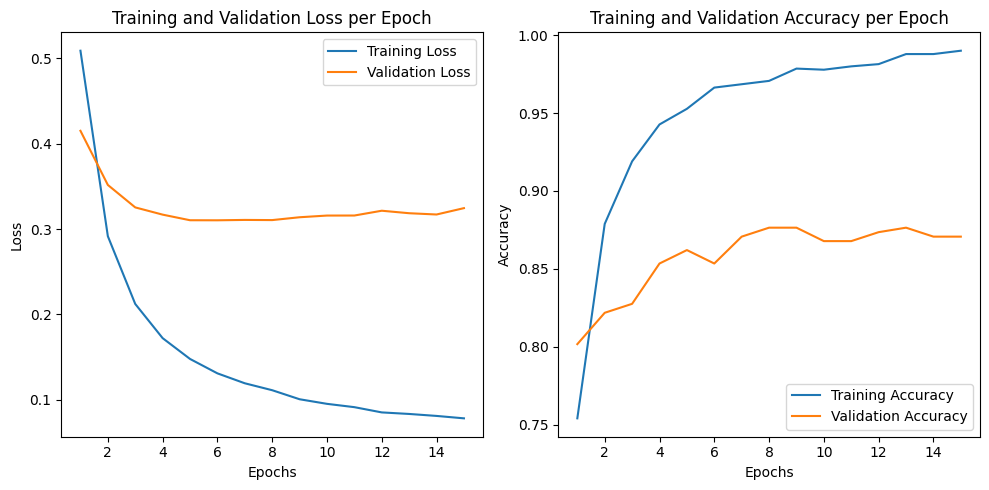

In [20]:
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value, epochs=epochs)

# بخش ج

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, seq_length, output_size, num_layers, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            h_size = self.num_layers * 2
            hid_size1 = hidden_size*seq_length*2
        else:
            h_size = self.num_layers
            hid_size1 = hidden_size*seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.init_hidden = nn.Parameter(torch.zeros(h_size, 1, hidden_size))
        self.init_cell = nn.Parameter(torch.zeros(h_size, 1, hidden_size))

        self.fc = nn.Linear(hid_size1, hidden_size2)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0.0)

        self.fc2 = nn.Linear(hidden_size2, output_size)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = self.init_hidden.expand(-1, batch_size, -1).contiguous()
        c0 = self.init_cell.expand(-1, batch_size, -1).contiguous()
        lstm_out, _ = self.lstm(x, (h0, c0))

        lstm_out = lstm_out.contiguous().view(lstm_out.shape[0], -1)
        output = self.fc(lstm_out)
        output = F.dropout(output, p=0.5, training=self.training)
        output = self.fc2(output)
        output = self.softmax(output)
        return output
        # return lstm_out

In [22]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

input_size = encoded_smiles[0][0].shape[1]
hidden_size = 32
hidden_size2 = 64
seq_length = 400
output_size = 2
num_layers = 2

epochs = 15

train_acc = []
val_acc = []
test_acc = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and validation sets
    train_set = torch.utils.data.Subset(train_val_dataset, train_idx)
    val_set = torch.utils.data.Subset(train_val_dataset, val_idx)

    # Create dataloaders for train and validation sets
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

    model_lstm = LSTMModel(input_size=input_size, hidden_size=hidden_size, hidden_size2=hidden_size2, seq_length=seq_length, output_size=output_size, num_layers=num_layers, bidirectional=False)
    criterion_ = nn.CrossEntropyLoss()
    optimizer_ = optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=0.01)

    train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value = train(model=model_lstm, train_loader=train_loader,
                                                                                        val_loader=val_loader, epochs=epochs, optimizer=optimizer_,
                                                                                        loss_function=criterion_)
    train_acc.append(train_accuracy_values[-1])
    val_acc.append(val_accuracy_value[-1])

    test_accuracy = test(model=model_lstm, test_loader=test_loader)
    test_acc.append(test_accuracy)
    if fold!=num_folds-1:
        del model_lstm
    torch.cuda.empty_cache()

print(f"train acc = {sum(train_acc)/num_folds}")
print(f"val acc = {sum(val_acc)/num_folds}")
print(f"test acc = {sum(test_acc)/num_folds}")

Fold 1/5
Train Loss: 0.3572, Train Accuracy: 84.00%
Validation Loss: 0.3523, Validation Accuracy: 84.24%
Finished Training
Test Accuracy: 84.04%
Fold 2/5
Train Loss: 0.3379, Train Accuracy: 85.58%
Validation Loss: 0.3405, Validation Accuracy: 85.39%
Finished Training
Test Accuracy: 85.02%
Fold 3/5
Train Loss: 0.3252, Train Accuracy: 85.65%
Validation Loss: 0.3576, Validation Accuracy: 86.82%
Finished Training
Test Accuracy: 84.69%
Fold 4/5
Train Loss: 0.3293, Train Accuracy: 85.23%
Validation Loss: 0.3390, Validation Accuracy: 84.77%
Finished Training
Test Accuracy: 84.04%
Fold 5/5
Train Loss: 0.3367, Train Accuracy: 85.02%
Validation Loss: 0.2935, Validation Accuracy: 88.22%
Finished Training
Test Accuracy: 84.69%
train acc = 0.8509752497904485
val acc = 0.8588709943022759
test acc = 0.8449511400651467


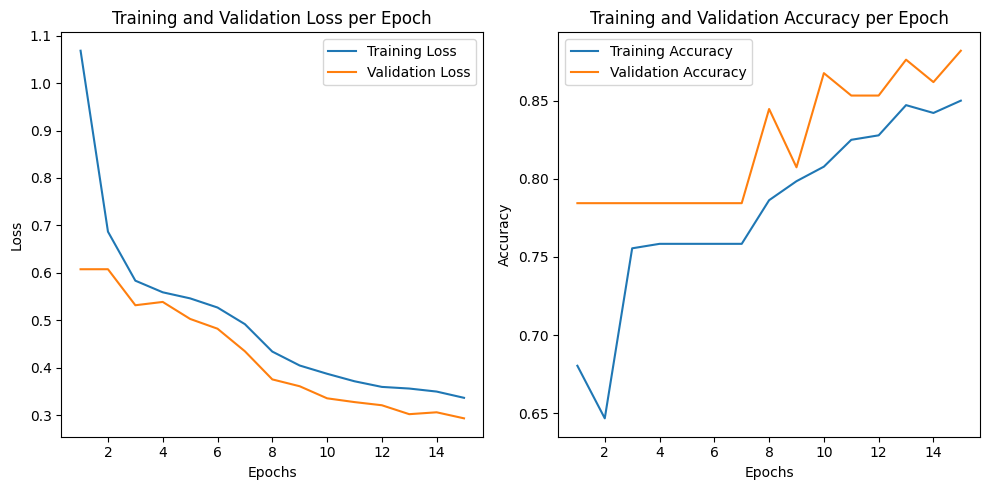

In [23]:
# test_accuracy = test(model=model_, test_loader=test_loader)
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value, epochs=epochs)

# بخش د

In [24]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

input_size = encoded_smiles[0][0].shape[1]
hidden_size = 32
hidden_size2 = 64
seq_length = 400
output_size = 2
num_layers = 2

epochs = 30

train_acc = []
val_acc = []
test_acc = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and validation sets
    train_set = torch.utils.data.Subset(train_val_dataset, train_idx)
    val_set = torch.utils.data.Subset(train_val_dataset, val_idx)

    # Create dataloaders for train and validation sets
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

    model_bilstm = LSTMModel(input_size=input_size, hidden_size=hidden_size, hidden_size2=hidden_size2, seq_length=seq_length, output_size=output_size, num_layers=num_layers, bidirectional=True)
    criterion_ = nn.CrossEntropyLoss()
    optimizer_ = optim.Adam(model_bilstm.parameters(), lr=0.001, weight_decay=0.01)

    train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value = train(model=model_bilstm, train_loader=train_loader,
                                                                                        val_loader=val_loader, epochs=epochs, optimizer=optimizer_,
                                                                                        loss_function=criterion_)
    train_acc.append(train_accuracy_values[-1])
    val_acc.append(val_accuracy_value[-1])

    test_accuracy = test(model=model_bilstm, test_loader=test_loader)
    test_acc.append(test_accuracy)
    if fold!=num_folds-1:
        del model_bilstm
    torch.cuda.empty_cache()

print(f"train acc = {sum(train_acc)/num_folds}")
print(f"val acc = {sum(val_acc)/num_folds}")
print(f"test acc = {sum(test_acc)/num_folds}")

Fold 1/5
Train Loss: 0.2767, Train Accuracy: 87.73%
Validation Loss: 0.3297, Validation Accuracy: 85.96%
Finished Training
Test Accuracy: 86.97%
Fold 2/5
Train Loss: 0.3061, Train Accuracy: 86.73%
Validation Loss: 0.3389, Validation Accuracy: 85.96%
Finished Training
Test Accuracy: 85.02%
Fold 3/5
Train Loss: 0.2990, Train Accuracy: 87.73%
Validation Loss: 0.3433, Validation Accuracy: 85.67%
Finished Training
Test Accuracy: 86.64%
Fold 4/5
Train Loss: 0.3196, Train Accuracy: 85.81%
Validation Loss: 0.2520, Validation Accuracy: 90.23%
Finished Training
Test Accuracy: 85.67%
Fold 5/5
Train Loss: 0.3082, Train Accuracy: 87.03%
Validation Loss: 0.2979, Validation Accuracy: 86.21%
Finished Training
Test Accuracy: 85.99%
train acc = 0.870053326339715
val acc = 0.8680598096367289
test acc = 0.8605863192182411


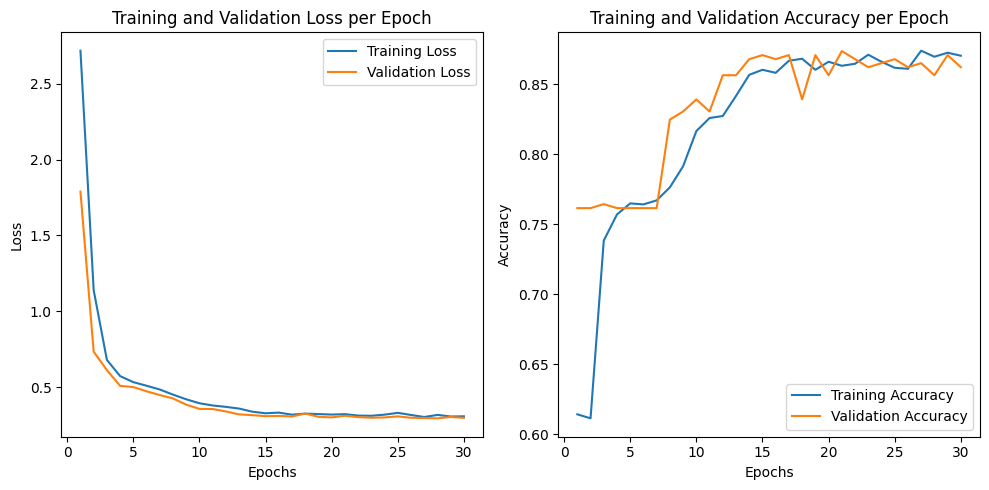

In [25]:
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value, epochs=epochs)

# بخش ه

تا همین الان تمامی بخش ها مبتنی بر cross validation بوده است.

# بخش و

# بخش ز

Test Accuracy: 90.00%
Test Accuracy: 83.33%
Test Accuracy: 83.33%
Test Accuracy: 80.00%
Test Accuracy: 76.67%
Test Accuracy: 76.67%
Test Accuracy: 90.00%
Test Accuracy: 100.00%
Test Accuracy: 96.67%
Test Accuracy: 90.00%
Test Accuracy: 83.33%
Test Accuracy: 90.00%
Test Accuracy: 96.67%
Test Accuracy: 86.67%
Test Accuracy: 86.67%
Test Accuracy: 80.00%
Test Accuracy: 83.33%
Test Accuracy: 86.67%
Test Accuracy: 90.00%
Test Accuracy: 83.33%
Test Accuracy: 83.33%
Test Accuracy: 86.67%
Test Accuracy: 90.00%
Test Accuracy: 86.67%
Test Accuracy: 80.00%
Test Accuracy: 80.00%
Test Accuracy: 86.67%
Test Accuracy: 83.78%
Test Accuracy: 81.08%
Test Accuracy: 83.78%


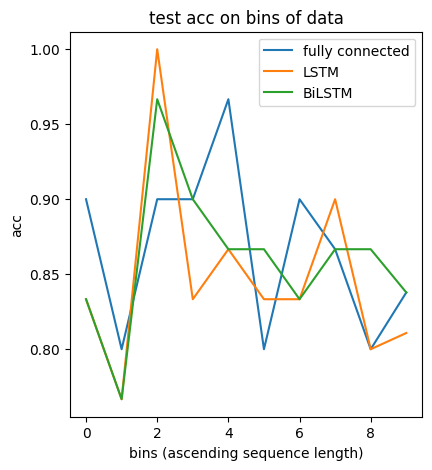

In [27]:
def get_len(data):
    i = 0
    for item in data:
        if all(val == 0 for val in item):
            break
        i+=1
    return i

sorted_test = sorted(list(test_dataset), key=lambda x: get_len(x[0]))
ll = len(sorted_test)//10
fc_res = []
lstm_res = []
bilstm_res = []
for bin in range(10):
    if bin!=9:
        test_loader_ = DataLoader(sorted_test[(bin*ll):((bin+1)*ll)], batch_size=1, shuffle=False)
    else:
        test_loader_ = DataLoader(sorted_test[(bin*ll):(len(sorted_test))], batch_size=1, shuffle=False)
    test_fc = test(model=model_fc, test_loader=test_loader_)
    test_lstm = test(model=model_lstm, test_loader=test_loader_)
    test_bilstm = test(model=model_bilstm, test_loader=test_loader_)
    fc_res.append(test_fc)
    lstm_res.append(test_lstm)
    bilstm_res.append(test_bilstm)

plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(fc_res, label='fully connected')
plt.plot(lstm_res, label='LSTM')
plt.plot(bilstm_res, label='BiLSTM')

plt.xlabel('bins (ascending sequence length)')
plt.ylabel('acc')
plt.title('test acc on bins of data')
plt.legend()

Test Accuracy: 88.28%
Test Accuracy: 86.72%
Test Accuracy: 87.50%
Test Accuracy: 86.36%
Test Accuracy: 84.85%
Test Accuracy: 84.85%
Test Accuracy: 81.08%
Test Accuracy: 78.38%
Test Accuracy: 86.49%
Test Accuracy: 66.67%
Test Accuracy: 66.67%
Test Accuracy: 66.67%
Test Accuracy: 100.00%
Test Accuracy: 83.33%
Test Accuracy: 83.33%
Test Accuracy: 100.00%
Test Accuracy: 100.00%
Test Accuracy: 100.00%


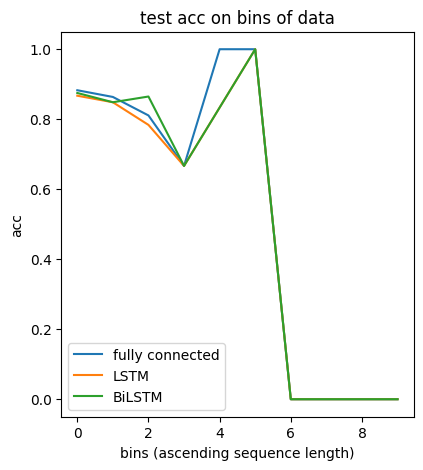

In [29]:


test_bins = [[], [], [], [], [], [], [], [], [], []]
for item in list(test_dataset):
    l = get_len(item[0])
    test_bins[(l-1)//40].append(item)

fc_res = []
lstm_res = []
bilstm_res = []
for bin in range(10):
    if len(test_bins[bin])==0:
        fc_res.append(0)
        lstm_res.append(0)
        bilstm_res.append(0)
        continue
    test_loader_ = DataLoader(test_bins[bin], batch_size=1, shuffle=False)
    test_fc = test(model=model_fc, test_loader=test_loader_)
    test_lstm = test(model=model_lstm, test_loader=test_loader_)
    test_bilstm = test(model=model_bilstm, test_loader=test_loader_)
    fc_res.append(test_fc)
    lstm_res.append(test_lstm)
    bilstm_res.append(test_bilstm)

plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(fc_res, label='fully connected')
plt.plot(lstm_res, label='LSTM')
plt.plot(bilstm_res, label='BiLSTM')

plt.xlabel('bins (ascending sequence length)')
plt.ylabel('acc')
plt.title('test acc on bins of data')
plt.legend()